In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

reports_dir = "dataset/ecgen-radiology"

reports = os.listdir(reports_dir)

def sort_key(report):
    return int(report.split(".")[0])

reports.sort(key=sort_key)
reports = [os.path.abspath(os.path.join(reports_dir, report)) for report in reports]


/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from bs4 import BeautifulSoup

def parse_report(report):
    f = open(report,'r')
    report_xml = f.readlines()     
    report_xml = ''.join(report_xml)
    report_parsed = BeautifulSoup(report_xml, "lxml")
    f.close()
    return report_parsed

def extract_path(report_parsed):
    xrays = report_parsed.findAll("parentimage")
    xray_paths = []
    for xray in xrays:
        xray_path = os.path.join("dataset", xray["id"] + ".png")
        xray_path = os.path.abspath(xray_path)
        xray_paths.append(xray_path)
    return xray_paths

def extract_label(report_parsed):
    
    majors = report_parsed.mesh.findAll("major")
    lb =[]
    for major in majors:
        if major.getText() == "normal":
            lb.append(0)
        else:
            lb.append(1)
            
    return lb

def build_dataset(reports):


    dataset =[]
    for report in tqdm(reports):
        parsed_report = parse_report(report)
        tmp_parsed_label = extract_label(parsed_report)
        tmp_parsed_path = extract_path(parsed_report)
        
        while ( len(tmp_parsed_label) < len(tmp_parsed_path) ) :
            tmp_parsed_label.append(tmp_parsed_label[0])
        
        tmp = np.minimum(len(tmp_parsed_label),len(tmp_parsed_path))
        for num in range(tmp):
            entry = {"path":tmp_parsed_path[num],"label":tmp_parsed_label[num]}
            dataset.append(entry)
    return dataset

dataset = build_dataset(reports)
dataset_rand = np.random.permutation(dataset)
np.save("dataset.npy",dataset_rand)

100%|██████████| 3955/3955 [00:24<00:00, 159.23it/s]


In [3]:
from keras.preprocessing import image

def preprocess_xray(xray_path):
    xray_img = image.load_img(xray_path,grayscale=True,
                             target_size=(224,224,1))
    xray_img = image.img_to_array(xray_img)
    xray_img = (xray_img - np.mean(xray_img[:]))/np.var(xray_img[:])
    return xray_img

  
def load_samples(dataset): #randomized dataset
    train_x, val_x, test_x = [], [], []
    train_y, val_y, test_y = [], [], []
    idx_max_train = int(float(len(dataset))*0.8)
    idx_max_val = int(float(len(dataset))*0.9)
    
    
    for idx, data in enumerate(tqdm(dataset)):
        #print(data["path"])
        x_array = np.array(preprocess_xray(data["path"]))
        y_array = np.array(data["label"])
        if(idx == 0):
            train_x = np.zeros((idx_max_train,*x_array.shape))
            train_y = np.zeros((idx_max_train,1))
            val_x = np.zeros((idx_max_val-idx_max_train,*x_array.shape))
            val_y = np.zeros((idx_max_val-idx_max_train))
            test_x = np.zeros((len(dataset)-idx_max_val,*x_array.shape))
            test_y = np.zeros((len(dataset)-idx_max_val,1))
       
            train_x[idx,:,:,:] = x_array
            train_y[idx] = y_array
            
        if(idx < idx_max_train):
            train_x[idx,:,:,:] = x_array
            train_y[idx] = y_array
            
            
        elif(idx < idx_max_val):
            val_x[idx-idx_max_train,:,:,:] = x_array
            val_y[idx-idx_max_train] = y_array
            
        else:
            test_x[idx-idx_max_val,:,:,:] = x_array
            test_y[idx-idx_max_val] = y_array
            
    X = [train_x, val_x, test_x]
    Y = [train_y, val_y, test_y]
    return X, Y



Using TensorFlow backend.


In [4]:
dataset_load = np.load("dataset.npy")
X,Y = load_samples(dataset_load)

train_x, val_x, test_x = X
train_y, val_y, test_y = Y

def Dataset(X, y, batch_size, shuffle=False):
    assert X.shape[0] == y.shape[0], 'The size of X and y are not matching'
    N,B = X.shape[0],batch_size
    if shuffle:
        idx = np.random.permutation(N)
        X = X[idx]
        y = y[idx]
            
    re = [(X[i:i+B,:,:,:], y[i:i+B,:] ) for i in range(0,N,B)]
    
    return re



100%|██████████| 7470/7470 [06:22<00:00, 18.00it/s]


In [5]:
# testing for PCA
#tmp = train_x[:,:,:,0].reshape((train_x.shape[0],-1))
#cov_mat=(tmp - np.mean(tmp,axis=0)).T.dot(tmp - np.mean(tmp,axis=0))/(tmp.shape[0]-1)
#eig_vals, eig_vecs = np.linalg.eig(cov_mat)
#print(np.cumsum(eig_vals))

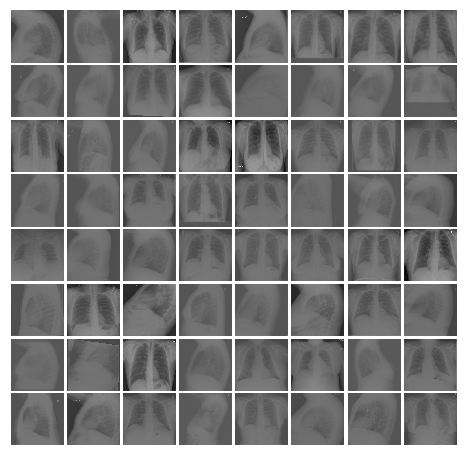

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize']
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    batch_size = images.shape[0]
    grid_rc = int(np.ceil(np.sqrt(images.shape[0]))) 
    fig = plt.figure(figsize=(grid_rc,grid_rc))
    gs = gridspec.GridSpec(grid_rc,grid_rc)
    gs.update(wspace=0.05,hspace=0.05)
    for num in range(batch_size):
        ax = plt.subplot(gs[num])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(images[num])
        
    return
x_resc = train_x[0:64,:,:,:]
x_resc = np.transpose(x_resc,[0,1,3,2])
x_resc = np.dstack([x_resc,x_resc,x_resc])
x_resc = np.transpose(x_resc,[0,1,3,2])
#print(x_resc.shape)
x_resc = x_resc - np.min(x_resc[:])
x_resc = x_resc/np.max(x_resc[:])

#print(x_resc.shape)
show_images(x_resc)
#print(train_y[0:64].reshape((8,8)))

In [11]:
import keras
import numpy as np
from datetime import datetime
from keras import optimizers
from keras.models import load_model
from sklearn.metrics import roc_auc_score


import sys
import numpy as np

from keras import backend as K
K.clear_session()

lr = 0.00001
lr_decay = 0.05
learning_rate_decay = 0.05
        
img_dims = (224, 224, 3)
device = '/gpu:0' 

def leaky_relu(x, alpha=0.01):

    x_relu = tf.maximum(x , 0) 
    x_leaky = tf.minimum(x, 0 ) * 0.01

    return x_relu + x_leaky 


def check_accuracy(sess,x,scores,val_dataset):
    num_sample = 0
    num_correct = 0
    for val_x,val_y in val_dataset:
        feed_dict = {x:val_x}
        scores_pred = sess.run([scores],feed_dict)
        y_pred = (scores_pred > 0.5)
        num_sample += val_x[0]
        num_correct += (y_pred == val_y).sum()
    return float(num_correct)/num_sample
        
class CNN(object):
    def set_layers(self,inputs,training):
       
        initializer = tf.initializers.variance_scaling() #          
        
        batch0 = tf.layers.batch_normalization(inputs)
        # 224x224
        # 224x224x1 -> 220x220x64
        a1 = tf.layers.conv2d(batch0,filters=32, kernel_size= 5, padding="valid",activation=leaky_relu,kernel_initializer=initializer)
        # 220x220x64 -> 110x110x64
        a1 = tf.layers.max_pooling2d(a1, 2, 2)

        # 110x110x64 -> 106x106x64
        a2 = tf.layers.conv2d(a1,filters=64, kernel_size= 5, padding="valid",activation=leaky_relu,kernel_initializer=initializer)
        # 106x106x64 -> 53x53x64
        a2 = tf.layers.max_pooling2d(a2, 2, 2)
        
        # 53X53X64 -> 50x50x128
        #a3 = tf.layers.conv2d(a2,filters=32, kernel_size= 4, padding="valid",activation=leaky_relu,kernel_initializer=initializer)
        # 50X50X128 -> 25x25x128
        #a3 = tf.layers.max_pooling2d(a3, 2, 2)
        
        a4 = tf.layers.dropout(a2,rate=0.5,training=training)
        a4 = tf.layers.flatten(a4)
        a4 = tf.layers.dense(a4,64,kernel_initializer=initializer,activation=leaky_relu)
        last = tf.layers.dense(a4,1,kernel_initializer=initializer)
        
      
        return last
    
    def construct_layers_and_run_training(self,train_dataset,learning_rate=0.0001,num_epochs=41):
        lrate = learning_rate
        tf.reset_default_graph()  
        with tf.device(device):
            x = tf.placeholder(tf.float32,[None,224,224,1])
            y = tf.placeholder(tf.float32,[None,1])
            is_training = tf.placeholder(tf.bool, name='is_training')
            
            scores = self.set_layers(x,training=True)
        
            loss_array = tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=scores)
            loss = tf.reduce_mean(loss_array)
            optimizer = tf.train.AdamOptimizer(learning_rate= lrate)
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)        
            with tf.control_dependencies(update_ops):
                train_op = optimizer.minimize(loss)
        
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            ite = 0
            
            try:
                saver.restore(sess, "tmp/model.ckpt")
                print("Model restored.")
            except FileNotFoundError:
                print("Model not restored")
            
            for epoch in range(num_epochs):
                avg = 0
                               
                for t, (train_X,train_y) in enumerate(train_dataset):
                    
                    feed_dict= {x:train_X, y:train_y, is_training:1}
                    loss_tf,scores_tf, _ = sess.run([loss,scores,train_op],feed_dict=feed_dict)
                    avg += loss_tf
                    
                    
            
                    
                print(avg/len(train_dataset))
                lrate = lrate * (1 - lr_decay)
                ite += 1
                
                if(epoch%4 == 0):
                    save_path = saver.save(sess, "tmp/model.ckpt")
                    print("Model saved in path: %s" % save_path)    
                    scores_tmp = np.zeros(train_y.shape)
                    scores_tmp = scores_tf > 0.5
                    train_y_tmp = train_y == 1
                    result = np.sum((scores_tmp == train_y).astype(int))/len(scores_tmp)
                    print("train_accuracy = %f" % result) 
                    
            #save_path = saver.save(sess, "tmp/model.ckpt")
            #print("Model saved in path: %s" % save_path) 
        
    def predict(self, test_x, test_y):
        
        lrate = 0.005      
        tf.reset_default_graph()  
        with tf.device(device):
            x = tf.placeholder(tf.float32,[None,224,224,1])
            y = tf.placeholder(tf.float32,[None,1])
            is_training = tf.placeholder(tf.bool, name='is_training')
            
            scores = self.set_layers(x,training=False)
        
            loss_array = tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=scores)
            loss = tf.reduce_mean(loss_array)
            

            optimizer = tf.train.AdamOptimizer(learning_rate= lrate)
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)        
            with tf.control_dependencies(update_ops):
                train_op = optimizer.minimize(loss)
        
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            try:
                #fh = open('tmp/model.ckpt','r')
                saver.restore(sess, "tmp/model.ckpt")
                print("Model restored.")
            except FileNotFoundError:
                print("Model not restored")
                
                
            feed_dict= {x:test_x, y:test_y, is_training:1}
            scores_tf, _ = sess.run([scores,train_op],feed_dict=feed_dict)
            #scores_tf = sess.run([scores],feed_dict=feed_dict)
                
            scores_tmp = np.zeros(test_y.shape)
            scores_tmp = scores_tf > 0.5
            test_y_tmp = test_y == 1
                
            result = np.sum((scores_tmp == test_y).astype(int))/len(scores_tmp)
            print(result) 
            
train_dataset = Dataset(train_x, train_y, 64, shuffle=False)       
model = CNN()

model.construct_layers_and_run_training(train_dataset)
print('accuracy on training dataset')
model.predict(train_x[0:40,:,:,:], train_y[0:40,:])
print('accuracy on test dataset')
model.predict(test_x[0:100,:,:,:], test_y[0:100,:])
#print(test_y.shape)



INFO:tensorflow:Restoring parameters from tmp/model.ckpt
Model restored.
0.019227558985956884
Model saved in path: tmp/model.ckpt
train_accuracy = 1.000000
0.014703743875601348
0.015141729111882283
0.016781694122015477
0.014629028530722048
Model saved in path: tmp/model.ckpt
train_accuracy = 1.000000
0.013123312779266308
0.010807010540837778
0.009874289830591767
0.010015403475374617
Model saved in path: tmp/model.ckpt
train_accuracy = 1.000000
0.010011607859075624
0.008777304357437893
0.009354819907457568
0.00969742146720664
Model saved in path: tmp/model.ckpt
train_accuracy = 1.000000
0.008753875520035743
0.007161863361846933
0.008123641174801804
0.009332331760657673
Model saved in path: tmp/model.ckpt
train_accuracy = 1.000000
0.012285789363383454
0.007086118514169047
0.00664423652330136
0.006008856115550635
Model saved in path: tmp/model.ckpt
train_accuracy = 1.000000
0.006308803030790048
0.0075027729592662545
0.008154206885089305
0.009791545218793041
Model saved in path: tmp/model.